In [30]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

import seaborn as sns
from data_preprocessing import load_combined_data
import torch.nn.functional as F

In [31]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # disables optimizations for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [32]:
# Load the combined_labels.npy file
output_dir = "./processed_data/"

# Load the saved NumPy arrays
combined_data = np.load(os.path.join(output_dir, "combined_data_train.npy"))
combined_labels = np.load(os.path.join(output_dir, "combined_label_train.npy"))

WITH K FOLD


--- Fold 1 ---
Epoch 1: Train Acc = 0.3903, Val Acc = 0.4588
Epoch 2: Train Acc = 0.4946, Val Acc = 0.4767
Epoch 3: Train Acc = 0.5018, Val Acc = 0.6452
Epoch 4: Train Acc = 0.6421, Val Acc = 0.7097
Epoch 5: Train Acc = 0.7230, Val Acc = 0.7957
Epoch 6: Train Acc = 0.7941, Val Acc = 0.8280
Epoch 7: Train Acc = 0.8156, Val Acc = 0.8315
Epoch 8: Train Acc = 0.8498, Val Acc = 0.8244
Epoch 9: Train Acc = 0.8579, Val Acc = 0.8602
Epoch 10: Train Acc = 0.8696, Val Acc = 0.8853
Epoch 11: Train Acc = 0.8858, Val Acc = 0.8889
Epoch 12: Train Acc = 0.8912, Val Acc = 0.8961
Epoch 13: Train Acc = 0.8957, Val Acc = 0.8853
Epoch 14: Train Acc = 0.8921, Val Acc = 0.8961
Epoch 15: Train Acc = 0.9056, Val Acc = 0.9104
Epoch 16: Train Acc = 0.9038, Val Acc = 0.9032
Epoch 17: Train Acc = 0.9155, Val Acc = 0.8925
Epoch 18: Train Acc = 0.9200, Val Acc = 0.8853
Epoch 19: Train Acc = 0.9308, Val Acc = 0.9176
Epoch 20: Train Acc = 0.9218, Val Acc = 0.9068
Epoch 21: Train Acc = 0.9191, Val Acc = 0.9176
Epoch 

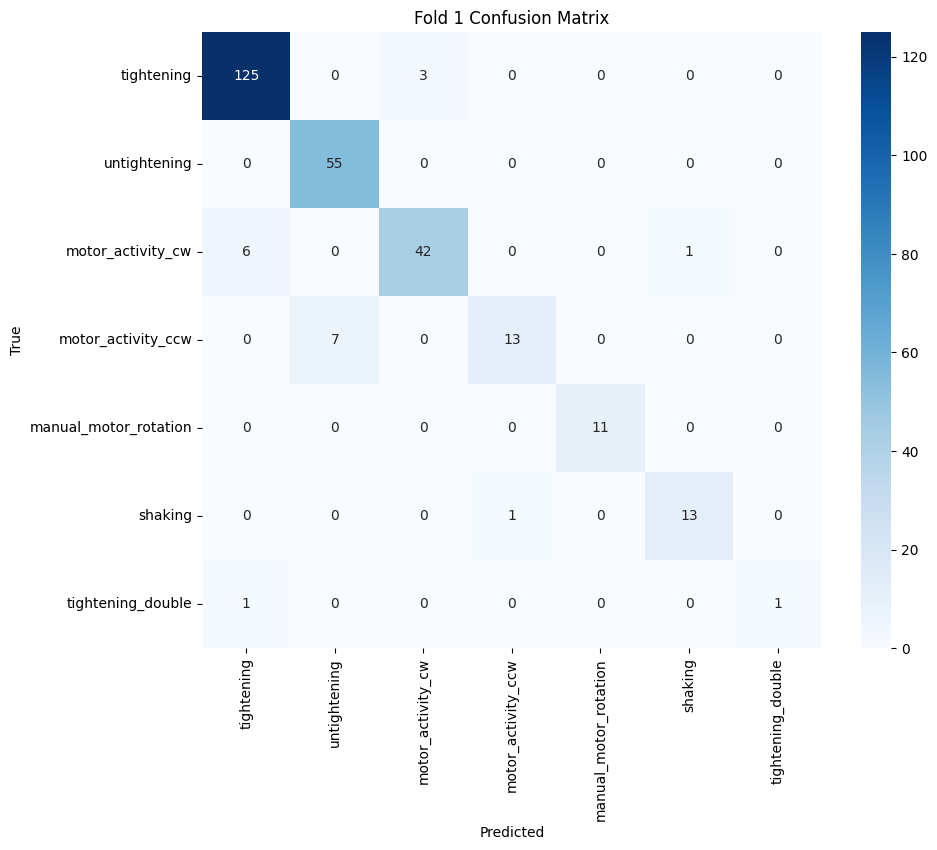


--- Fold 2 ---
Epoch 1: Train Acc = 0.4205, Val Acc = 0.4676
Epoch 2: Train Acc = 0.4852, Val Acc = 0.4820
Epoch 3: Train Acc = 0.4978, Val Acc = 0.5108
Epoch 4: Train Acc = 0.5651, Val Acc = 0.6367
Epoch 5: Train Acc = 0.6855, Val Acc = 0.6799
Epoch 6: Train Acc = 0.7457, Val Acc = 0.7878
Epoch 7: Train Acc = 0.8077, Val Acc = 0.8129
Epoch 8: Train Acc = 0.8248, Val Acc = 0.8345
Epoch 9: Train Acc = 0.8535, Val Acc = 0.8597
Epoch 10: Train Acc = 0.8652, Val Acc = 0.8741
Epoch 11: Train Acc = 0.8796, Val Acc = 0.8921
Epoch 12: Train Acc = 0.8922, Val Acc = 0.8993
Epoch 13: Train Acc = 0.8850, Val Acc = 0.8993
Epoch 14: Train Acc = 0.8868, Val Acc = 0.8525
Epoch 15: Train Acc = 0.8769, Val Acc = 0.8993
Epoch 16: Train Acc = 0.8976, Val Acc = 0.8993
Epoch 17: Train Acc = 0.8868, Val Acc = 0.9281
Epoch 18: Train Acc = 0.8985, Val Acc = 0.9029
Epoch 19: Train Acc = 0.8967, Val Acc = 0.9065
Epoch 20: Train Acc = 0.9048, Val Acc = 0.9209
Epoch 21: Train Acc = 0.9012, Val Acc = 0.9281
Epoch 

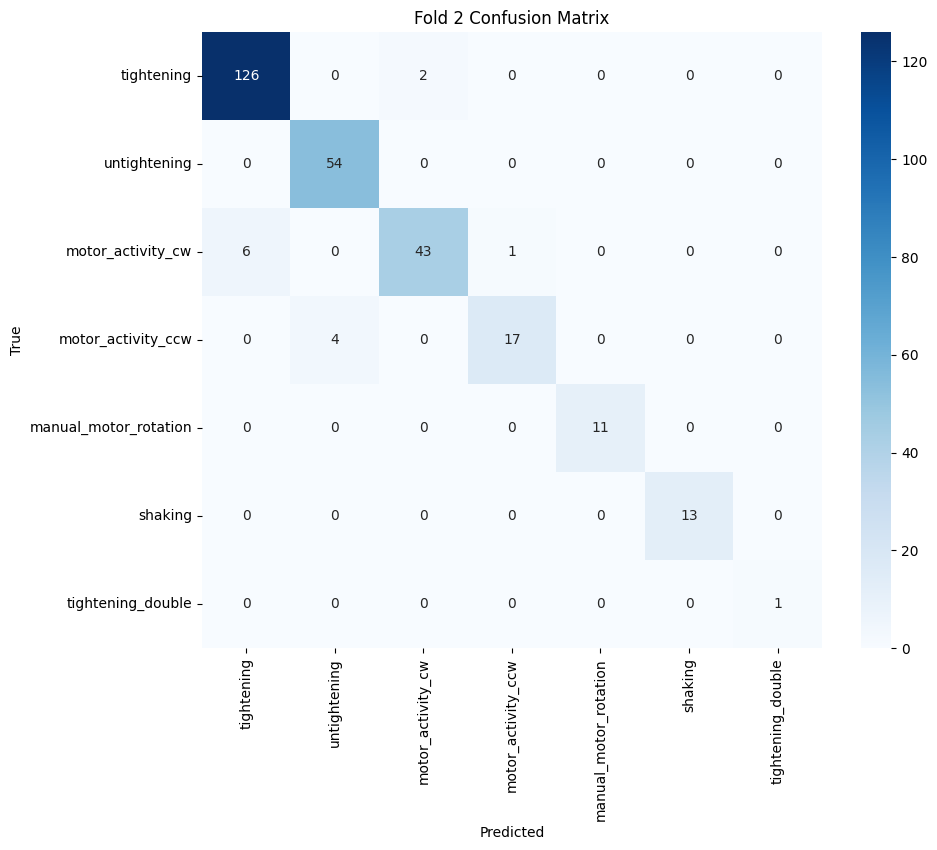


--- Fold 3 ---
Epoch 1: Train Acc = 0.3675, Val Acc = 0.4604
Epoch 2: Train Acc = 0.4888, Val Acc = 0.5252
Epoch 3: Train Acc = 0.5732, Val Acc = 0.6223
Epoch 4: Train Acc = 0.6703, Val Acc = 0.7518
Epoch 5: Train Acc = 0.7619, Val Acc = 0.7950
Epoch 6: Train Acc = 0.8212, Val Acc = 0.8129
Epoch 7: Train Acc = 0.8320, Val Acc = 0.8633
Epoch 8: Train Acc = 0.8527, Val Acc = 0.8777
Epoch 9: Train Acc = 0.8760, Val Acc = 0.8885
Epoch 10: Train Acc = 0.8949, Val Acc = 0.8813
Epoch 11: Train Acc = 0.8994, Val Acc = 0.9065
Epoch 12: Train Acc = 0.9093, Val Acc = 0.9209
Epoch 13: Train Acc = 0.9075, Val Acc = 0.8921
Epoch 14: Train Acc = 0.9182, Val Acc = 0.8921
Epoch 15: Train Acc = 0.9164, Val Acc = 0.9029
Epoch 16: Train Acc = 0.9119, Val Acc = 0.9137
Epoch 17: Train Acc = 0.9200, Val Acc = 0.8885
Epoch 18: Train Acc = 0.9173, Val Acc = 0.8993
Epoch 19: Train Acc = 0.9236, Val Acc = 0.9137
Epoch 20: Train Acc = 0.8958, Val Acc = 0.9173
Epoch 21: Train Acc = 0.9272, Val Acc = 0.9245
Epoch 

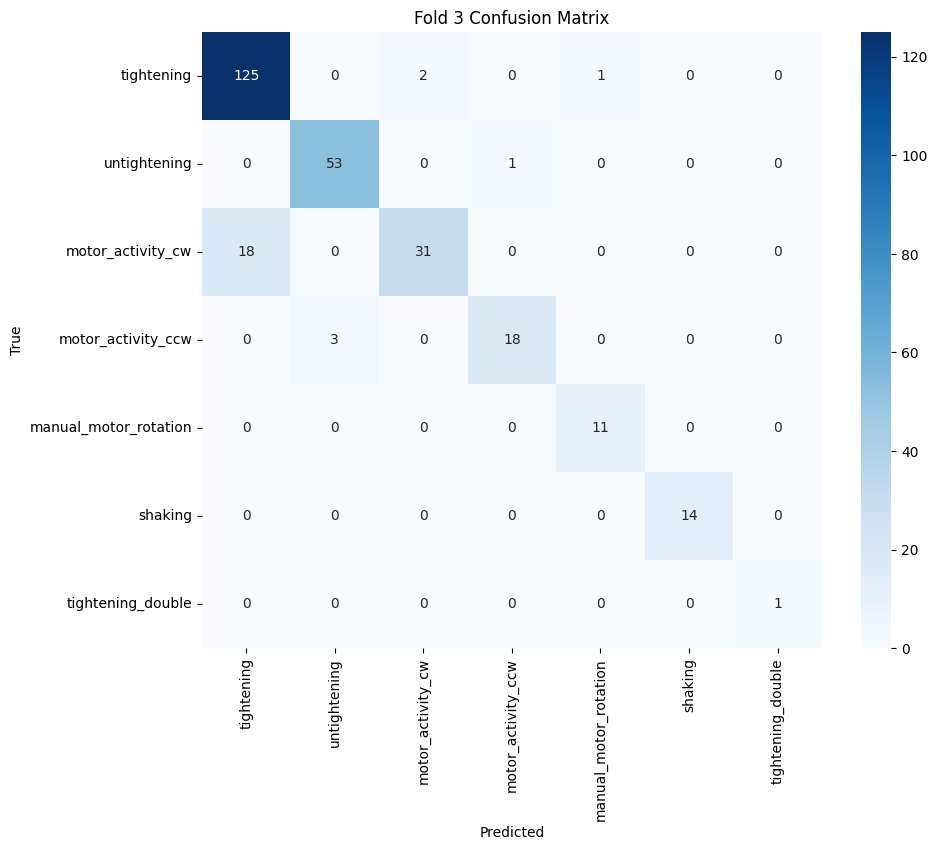


--- Fold 4 ---
Epoch 1: Train Acc = 0.3540, Val Acc = 0.4568
Epoch 2: Train Acc = 0.4627, Val Acc = 0.4568
Epoch 3: Train Acc = 0.4996, Val Acc = 0.5647
Epoch 4: Train Acc = 0.6110, Val Acc = 0.6655
Epoch 5: Train Acc = 0.7296, Val Acc = 0.7734
Epoch 6: Train Acc = 0.7817, Val Acc = 0.8309
Epoch 7: Train Acc = 0.8356, Val Acc = 0.8201
Epoch 8: Train Acc = 0.8464, Val Acc = 0.8561
Epoch 9: Train Acc = 0.8814, Val Acc = 0.8633
Epoch 10: Train Acc = 0.8913, Val Acc = 0.8921
Epoch 11: Train Acc = 0.8931, Val Acc = 0.8669
Epoch 12: Train Acc = 0.9039, Val Acc = 0.8885
Epoch 13: Train Acc = 0.9012, Val Acc = 0.9065
Epoch 14: Train Acc = 0.9155, Val Acc = 0.8777
Epoch 15: Train Acc = 0.9173, Val Acc = 0.8849
Epoch 16: Train Acc = 0.9128, Val Acc = 0.9101
Epoch 17: Train Acc = 0.9236, Val Acc = 0.9101
Epoch 18: Train Acc = 0.9209, Val Acc = 0.9101
Epoch 19: Train Acc = 0.9200, Val Acc = 0.8777
Epoch 20: Train Acc = 0.9209, Val Acc = 0.9101
Epoch 21: Train Acc = 0.9146, Val Acc = 0.9101
Epoch 

c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

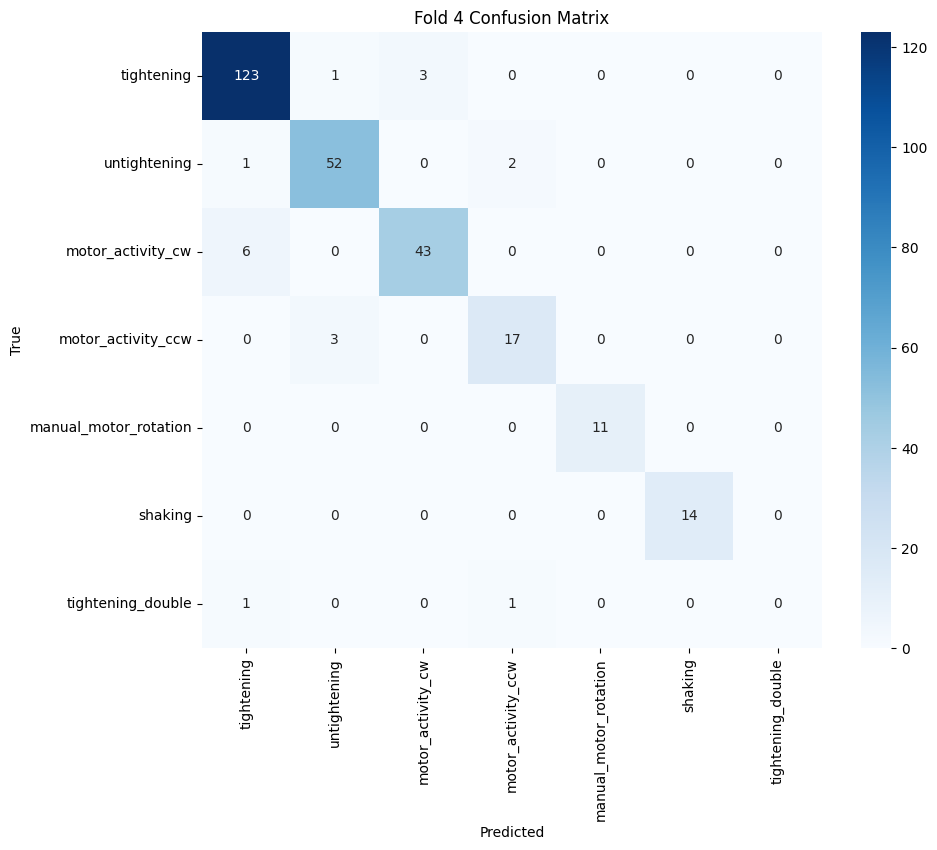


--- Fold 5 ---
Epoch 1: Train Acc = 0.3585, Val Acc = 0.4568
Epoch 2: Train Acc = 0.4744, Val Acc = 0.4568
Epoch 3: Train Acc = 0.4906, Val Acc = 0.4820
Epoch 4: Train Acc = 0.6047, Val Acc = 0.6691
Epoch 5: Train Acc = 0.6927, Val Acc = 0.7158
Epoch 6: Train Acc = 0.7592, Val Acc = 0.7446
Epoch 7: Train Acc = 0.8203, Val Acc = 0.8705
Epoch 8: Train Acc = 0.8571, Val Acc = 0.9209
Epoch 9: Train Acc = 0.8679, Val Acc = 0.9281
Epoch 10: Train Acc = 0.8859, Val Acc = 0.9388
Epoch 11: Train Acc = 0.8886, Val Acc = 0.9353
Epoch 12: Train Acc = 0.8985, Val Acc = 0.9245
Epoch 13: Train Acc = 0.9075, Val Acc = 0.9460
Epoch 14: Train Acc = 0.9200, Val Acc = 0.9532
Epoch 15: Train Acc = 0.9146, Val Acc = 0.9532
Epoch 16: Train Acc = 0.9236, Val Acc = 0.9424
Epoch 17: Train Acc = 0.9111, Val Acc = 0.9496
Epoch 18: Train Acc = 0.9209, Val Acc = 0.9532
Epoch 19: Train Acc = 0.9146, Val Acc = 0.9460
Epoch 20: Train Acc = 0.9299, Val Acc = 0.9460
Epoch 21: Train Acc = 0.9236, Val Acc = 0.9676
Epoch 

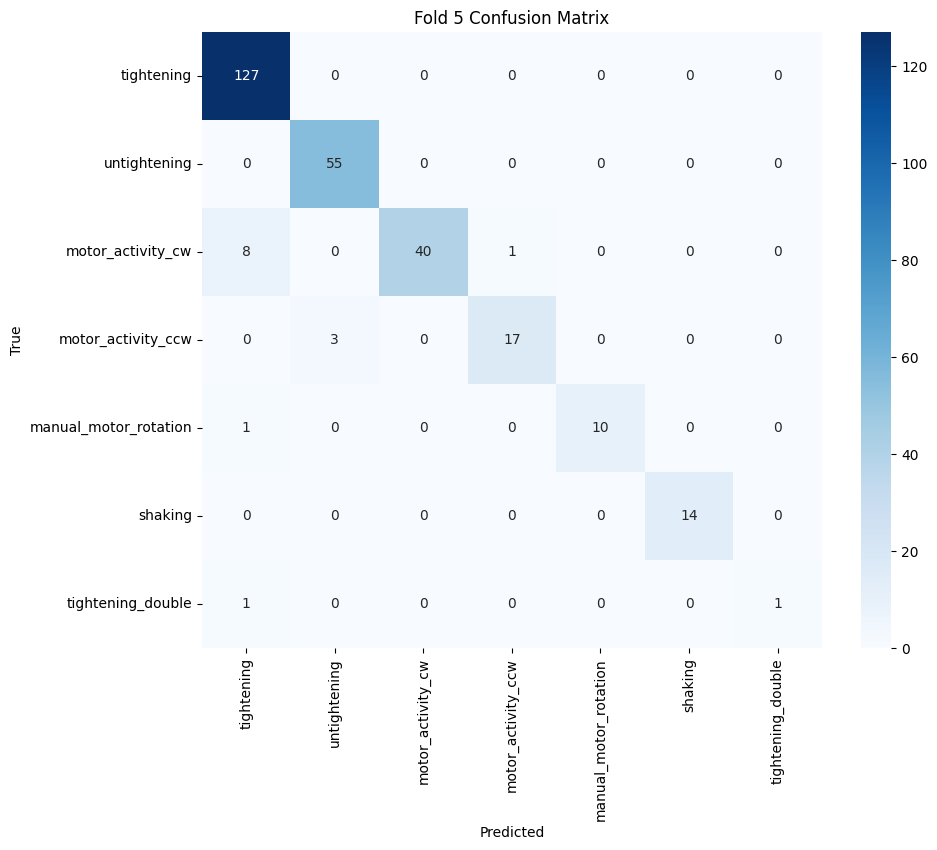


Average Accuracy over 5 folds: 0.9360
Average Weighted F1 Score over 5 folds: 0.9331


In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Label Mapping and Preprocessing ---------------- #
label_info = {
    2: 'tightening',
    3: 'untightening',
    4: 'motor_activity_cw',
    5: 'motor_activity_ccw',
    6: 'manual_motor_rotation',
    7: 'shaking',
    14: 'tightening_double'
}
valid_labels = list(label_info.keys())
valid_indices = np.isin(combined_labels, valid_labels)
X = combined_data[valid_indices]
y = combined_labels[valid_indices]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y_encoded)

# ---------------- Model and Loss ---------------- #
class EnhancedToolLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(EnhancedToolLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.dropout(last_out)
        return self.fc(out)

class SimpleFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(SimpleFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha, dtype=torch.float32) if alpha is not None else None

    def forward(self, inputs, targets):
        device = inputs.device
        log_probs = F.log_softmax(inputs, dim=1)
        probs = log_probs.exp()
        log_probs_true = log_probs.gather(1, targets.view(-1, 1)).squeeze(1)
        probs_true = probs.gather(1, targets.view(-1, 1)).squeeze(1).clamp(min=1e-9)
        if self.alpha is not None:
            alpha_t = self.alpha.to(device)[targets]
            loss = -alpha_t * (1 - probs_true)**self.gamma * log_probs_true
        else:
            loss = - (1 - probs_true)**self.gamma * log_probs_true
        return loss.mean()

# ---------------- K-Fold Training Loop ---------------- #
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X.shape[2]
output_dim = len(label_info)
hidden_dim = 64
batch_size = 32
num_epochs = 100

fold_accuracies, fold_f1s = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_tensor, y_tensor)):
    print(f"\n--- Fold {fold+1} ---")

    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    model = EnhancedToolLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
    criterion = SimpleFocalLoss(gamma=2.0)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        valid_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        valid_losses.append(valid_loss / len(val_loader))
        valid_accuracies.append(correct / total)
        print(f"Epoch {epoch+1}: Train Acc = {train_accuracies[-1]:.4f}, Val Acc = {valid_accuracies[-1]:.4f}")

    # Final Evaluation
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    fold_accuracies.append(acc)
    fold_f1s.append(f1)

    print(f"\nFold {fold+1} Accuracy: {acc:.4f}")
    print(f"Fold {fold+1} Weighted F1 Score: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=[label_info[i] for i in valid_labels]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_info.values(), yticklabels=label_info.values())
    plt.title(f'Fold {fold+1} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# ---------------- Overall Summary ---------------- #
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(fold_accuracies):.4f}")
print(f"Average Weighted F1 Score over {n_splits} folds: {np.mean(fold_f1s):.4f}")


SAVE MODEL

In [34]:
# Define directory for saving
model_dir = "./trained_model/"
os.makedirs(model_dir, exist_ok=True)

# File path to save the weights
model_file = os.path.join(model_dir, "enhanced_lstm_model.pth")

# Save the state dictionary
torch.save(model.state_dict(), model_file)

print(f"Model successfully saved to {model_file}.")


Model successfully saved to ./trained_model/enhanced_lstm_model.pth.


LOAD MODEL FOR TESTING

In [35]:
# Reload the model with the SAME architecture first
model = EnhancedToolLSTM(input_dim=X.shape[2],
                           hidden_dim=64,
                           output_dim=num_of_classes)
model.to(device)

# File path for the trained weights
model_file = os.path.join(model_dir, "enhanced_lstm_model.pth")

# Loading weights into the new instance
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print("Model successfully loaded.")


Model successfully loaded.


In [36]:
# Load the combined_labels.npy file
output_dir = "./processed_data/"

# Load the saved NumPy arrays
combined_data = np.load(os.path.join(output_dir, "combined_data_test.npy"))
combined_labels = np.load(os.path.join(output_dir, "combined_label_test.npy"))

# Label mapping
label_info = {
    2: 'tightening',
    3: 'untightening',
    4: 'motor_activity_cw',
    5: 'motor_activity_ccw',
    6: 'manual_motor_rotation',
    7: 'shaking',
    14: 'tightening_double'
}

valid_labels = list(label_info.keys())
valid_indices = np.isin(combined_labels, valid_labels)
# X = combined_data[valid_indices]
X = combined_data[valid_indices]
y = combined_labels[valid_indices]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) # can be removed as our code uses binary labels directly

# Convert to tensors
X_tensor_test = torch.FloatTensor(X)
y_tensor_test = torch.LongTensor(y_encoded)

Accuracy = 0.9220055710306406
F1 Score = 0.9179270754267338
Classification Report:
                       precision    recall  f1-score   support

           tightening       0.94      0.98      0.96       183
         untightening       0.84      1.00      0.91        61
    motor_activity_cw       0.95      0.79      0.86        52
   motor_activity_ccw       0.90      0.62      0.73        29
manual_motor_rotation       1.00      0.92      0.96        12
              shaking       0.95      1.00      0.97        18
    tightening_double       1.00      0.50      0.67         4

             accuracy                           0.92       359
            macro avg       0.94      0.83      0.87       359
         weighted avg       0.93      0.92      0.92       359

Confusion Matrix:
[[180   1   2   0   0   0   0]
 [  0  61   0   0   0   0   0]
 [  9   0  41   2   0   0   0]
 [  0  11   0  18   0   0   0]
 [  0   0   0   0  11   1   0]
 [  0   0   0   0   0  18   0]
 [  2   0   0   0

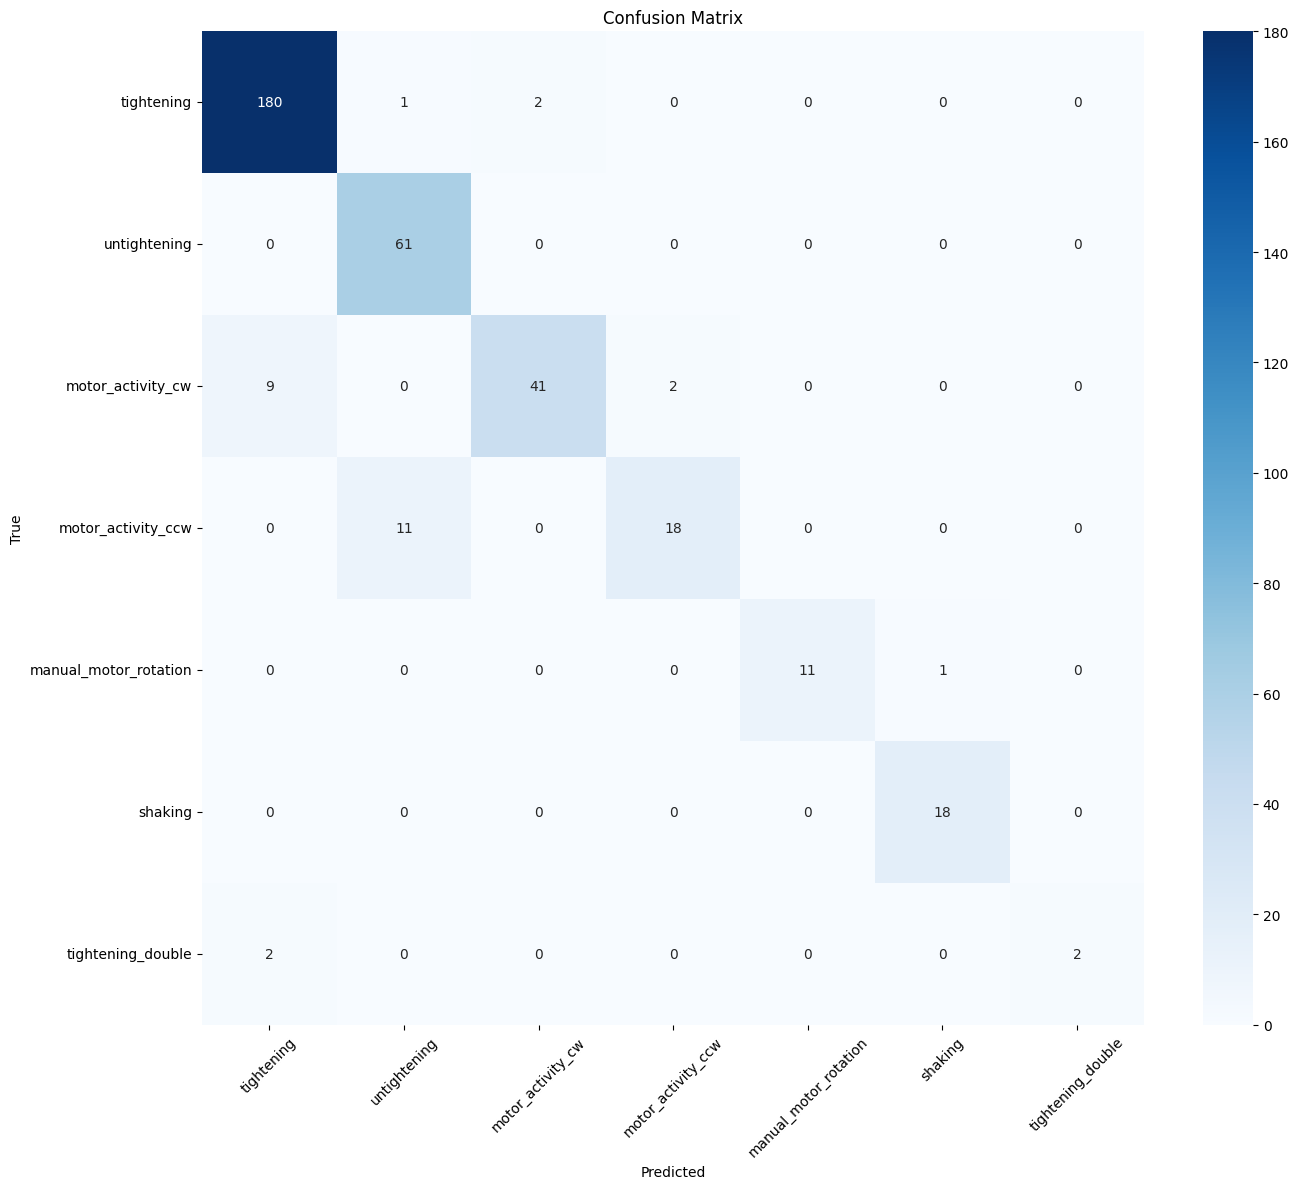


Classification Report:
                       precision    recall  f1-score   support

           tightening       0.94      0.98      0.96       183
         untightening       0.84      1.00      0.91        61
    motor_activity_cw       0.95      0.79      0.86        52
   motor_activity_ccw       0.90      0.62      0.73        29
manual_motor_rotation       1.00      0.92      0.96        12
              shaking       0.95      1.00      0.97        18
    tightening_double       1.00      0.50      0.67         4

             accuracy                           0.92       359
            macro avg       0.94      0.83      0.87       359
         weighted avg       0.93      0.92      0.92       359



<Figure size 640x480 with 0 Axes>

In [ ]:
# If you have new data in new_X and new_y
# create a DataLoader first:
new_loader = DataLoader(TensorDataset(X_tensor_test, y_tensor_test), batch_size=batch_size, shuffle=False)

# test_losses, test_accuracies = [], []
# for epoch in range(num_epochs):
#     model.eval()
#     test_loss, correct, total = 0.0, 0, 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)

#     test_losses.append(test_loss / len(test_loader))
#     test_accuracies.append(correct / total)

# Perform evaluation:
model.eval()
predicted_labels = []
true_labels = []


with torch.no_grad():
    for inputs, labels in new_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        predicted_labels.extend(preds.cpu().numpy()) 
        true_labels.extend(labels.numpy()) 


# Now you can compute metrics
print("Accuracy =", accuracy_score(true_labels, predicted_labels))
print("F1 Score =", f1_score(true_labels, predicted_labels, average='weighted'))
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

# Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final Weighted F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = [label_info[i] for i in valid_labels]
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# # Training Curves
# plt.figure(figsize=(20, 6))
# plt.subplot(1, 2, 1)
# plt.plot(train_losses, label='Train Loss')
# plt.plot(test_losses, label='Test Loss')
# plt.legend()
# plt.title('Loss over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

# plt.subplot(1, 2, 2)
# plt.plot(train_accuracies, label='Train Acc')
# plt.plot(test_accuracies, label='Test Acc')
# plt.legend()
# plt.title('Accuracy over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()
